# Install and Set up

In [4]:
# !pip install rl4co==0.3.3
# !pip install torch==2.3.0
# !pip install matplotlib

# Build Model and test untrained model

In [5]:
from SPPembeddings import SPPInitEmbedding, SPPContext, StaticEmbedding
from rl4co.models.zoo import AttentionModel, AutoregressivePolicy, POMO, POMOPolicy
from SPPenv import SPPEnv
from FPenv import FPEnv

env = FPEnv(fp_path="Floorplans/RL/Chicago/floorplan.json")

# Instantiate policy with the embeddings we created above
emb_dim = 64
# policy = AutoregressivePolicy(env,
#                               embedding_dim=emb_dim,
#                               init_embedding=SPPInitEmbedding(emb_dim),
#                               context_embedding=SPPContext(emb_dim),
#                               dynamic_embedding=StaticEmbedding(emb_dim)
# )

policy = POMOPolicy(env,
                    embedding_dim=emb_dim,
                    init_embedding=SPPInitEmbedding(emb_dim),
                    context_embedding=SPPContext(emb_dim),
                    dynamic_embedding=StaticEmbedding(emb_dim),
                    train_decode_type="greedy",
                    val_decode_type="greedy",
                    test_decode_type="greedy"
                    )

# model = POMO(env, policy=policy,
#                   baseline='shared',
#                   batch_size=3,
#                   train_data_size=500,
#                   val_data_size=100,)

# Model: default is AM with REINFORCE and greedy rollout baseline
model = AttentionModel(env,
                       policy=policy,
                       baseline='rollout',
                       train_data_size=100_00,
                       val_data_size=200_0,
                       batch_size=8,
                       val_batch_size=8,
                       test_batch_size=8
                       )

Problem 1 | Cost: 61.000
Actions Sizes: torch.Size([61])
Actions indices: tensor([148, 133,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
        108, 109, 110, 111, 112, 137, 119, 120, 121, 122, 123,   0,   1,   2,
          3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,
         17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27, 135,  28,  29,
         30, 118, 113, 114, 115])
Problem 2 | Cost: 114.000
Actions Sizes: torch.Size([114])
Actions indices: tensor([ 28,  29,  30, 118, 113, 114, 115, 116, 117,  31,  33,  44,  45,  46,
         47,  58,  59,  60,  61,  62,  63,  64,  65,  66, 126, 143, 136, 144,
        131,  67,  68,  69,  70,  71,  73,  74,  75,  76,  77,  78,  79,  80,
        127, 145, 146, 132,  81,  82,  83,  84,  85,  86,  87,  88,  91,  92,
         93,  94,  95, 128, 147, 134, 148, 133,  96,  97,  98,  99, 100, 101,
        102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 137, 119, 120,
        121, 122, 123,   0,   1,   2

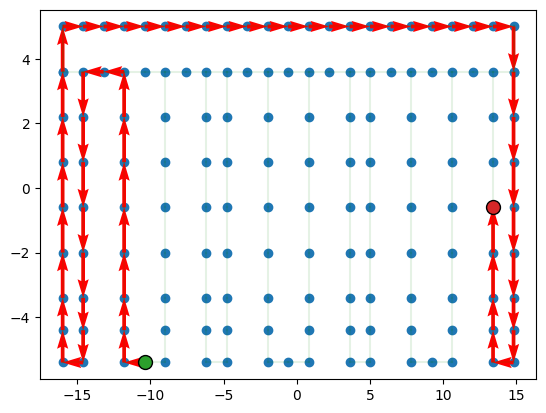

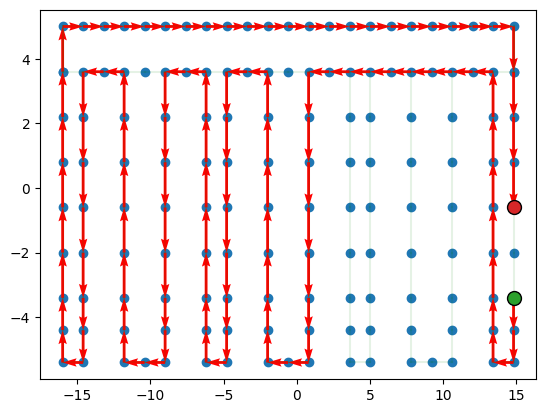

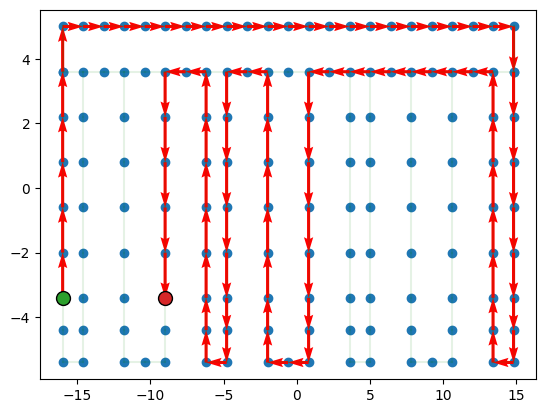

In [6]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
td_init = env.reset(batch_size=[4]).to(device)
model = model.to(device)
out = model(td_init.clone(), phase="test", decode_type="greedy", return_actions=True)
actions_untrained = out["actions"].cpu().detach()
rewards_untrained = out["reward"].cpu().detach()

for i in range(3):
    print(f"Problem {i+1} | Cost: {-rewards_untrained[i]:.3f}")
    env.render(td_init[i], actions_untrained[i])

# Train model

In [7]:
from rl4co.utils.trainer import RL4COTrainer

trainer = RL4COTrainer(
    max_epochs=100,
    accelerator="gpu",
    devices=1,
    logger=None
)

trainer.fit(model)

# Save the model
torch.save(model, 'Models/TrainOnChicagoV1.pth')

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
val_file not set. Generating dataset instead
test_file not set. Generating dataset instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type           | Params | Mode 
----------------------------------------------------
0 | env      | FPEnv          | 0      | train
1 | policy   | POMOPolicy     | 527 K  | train
2 | baseline | WarmupBaseline | 527 K  | train
----------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.217     Total estimated model params size (MB)
102       Modules in train mode
98        Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  8.31it/s, v_num=40, train/reward=-45.8, train/loss=0.353, val/reward=-50.8]   

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  5.46it/s, v_num=40, train/reward=-45.8, train/loss=0.353, val/reward=-50.8]


# Test trained model on floorplan


Actions Sizes: torch.Size([61])
Actions indices: tensor([148, 133,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
        108, 109, 110, 111, 112, 137, 119, 120, 121, 122, 123,   0,   1,   2,
          3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,
         17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27, 135,  28,  29,
         30, 118, 113, 114, 115])
Actions Sizes: torch.Size([47])
Actions indices: tensor([148, 133,  96,  97,  98,  99, 100, 101, 102, 103,  90,   0,   1,   2,
          3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,
         17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27, 135,  28,  29,
         30, 118, 113, 114, 115])
Actions Sizes: torch.Size([48])
Actions indices: tensor([134, 148, 133,  96,  97,  98,  99, 100, 101, 102, 103,  90,   0,   1,
          2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,
         16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27, 135,  28,
     

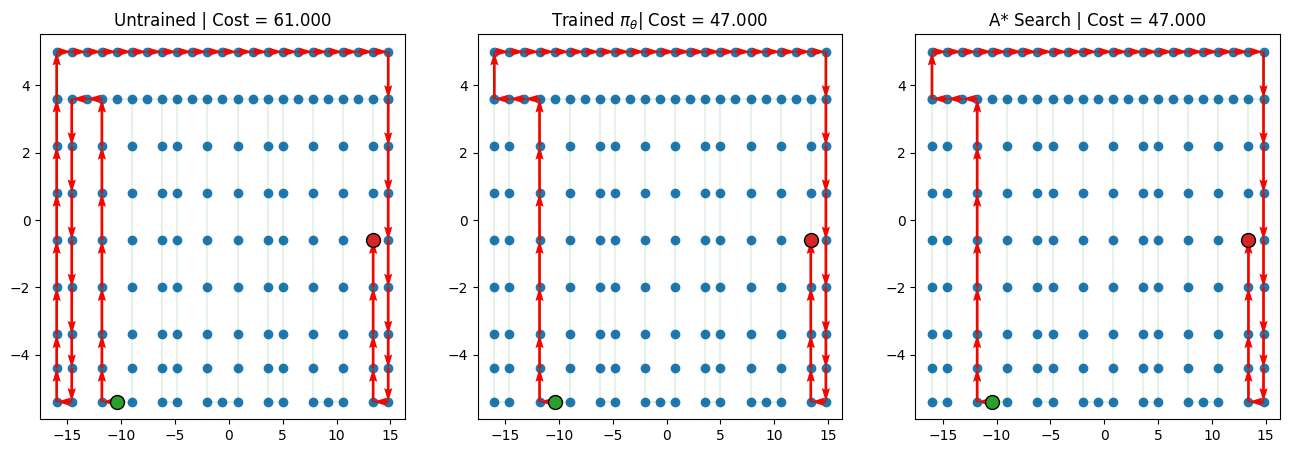

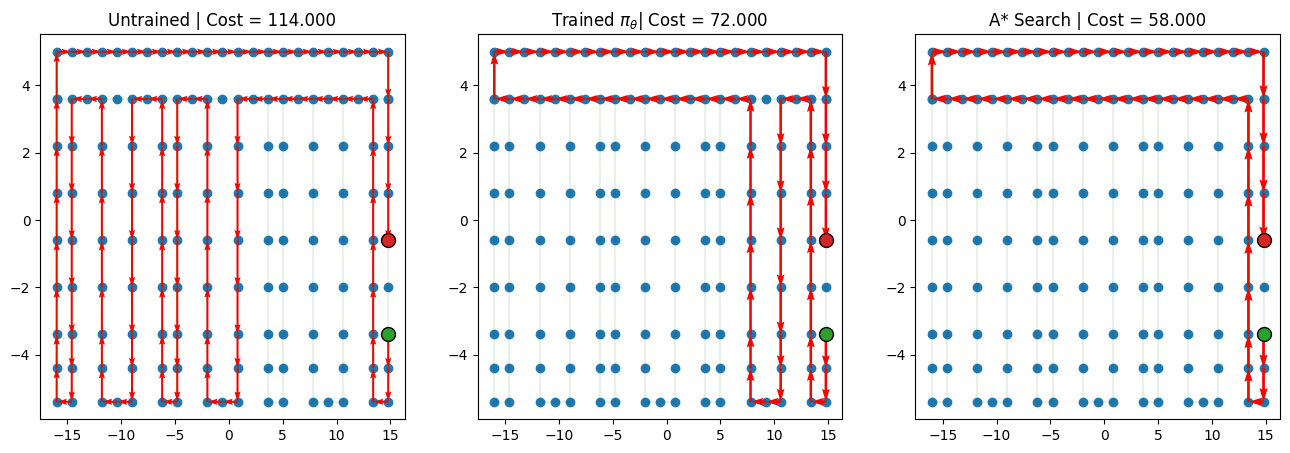

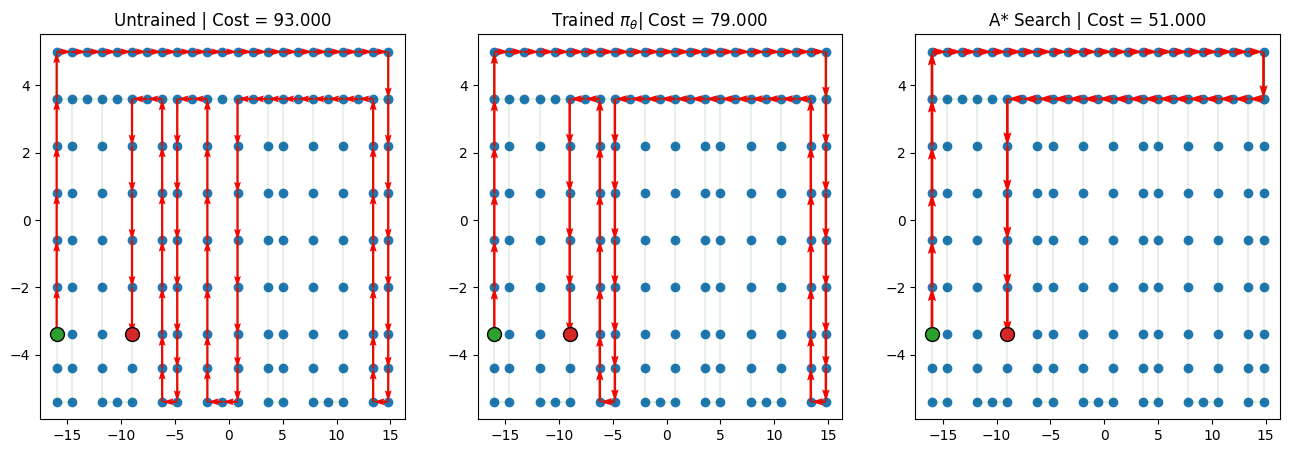

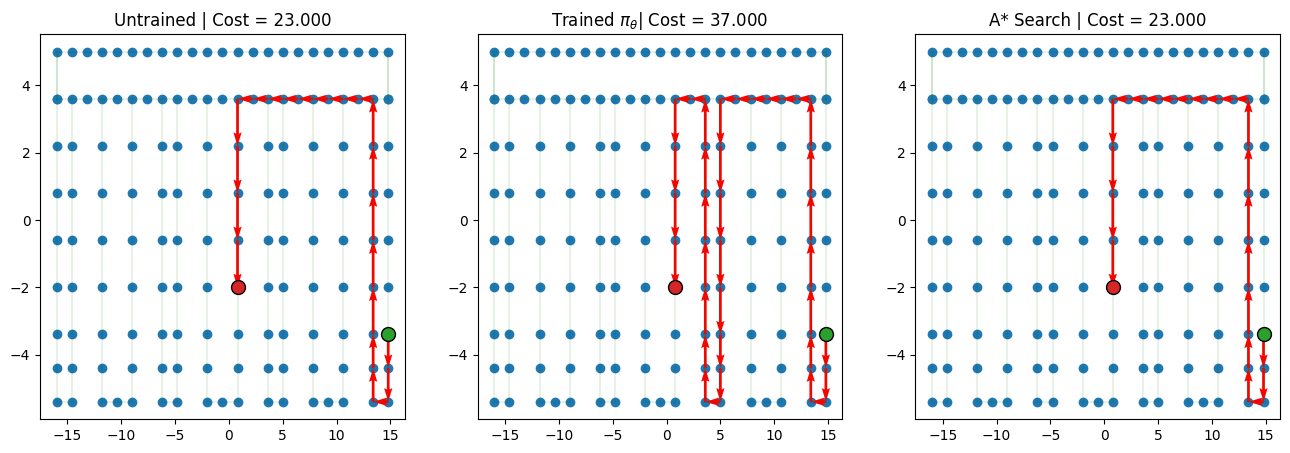

In [8]:
from astar import AStarSearch

policy = model.policy.to(device)
out = policy(td_init.clone(), env, phase="test", decode_type="greedy", return_actions=True)
actions_trained = out['actions'].cpu().detach()

# run A* search on the environment
astar = AStarSearch(td_init.clone())
astar_out = astar.search()
actions_astar = astar_out["actions"].cpu().detach()

# Plotting
import matplotlib.pyplot as plt
for i, td in enumerate(td_init):
    fig, axs = plt.subplots(1,3, figsize=(16,5))
    env.render(td, actions_untrained[i], ax=axs[0])
    axs[0].set_title(f"Untrained | Cost = {-rewards_untrained[i].item():.3f}")

    env.render(td, actions_trained[i], ax=axs[1])
    axs[1].set_title(r"Trained $\pi_\theta$" + f"| Cost = {-out['reward'][i].item():.3f}")

    env.render(td, actions_astar[i], ax=axs[2])
    axs[2].set_title("A* Search | Cost = {:.3f}".format(-astar_out["reward"][i].item()))